## Goal: compare the ground truth model to a model trained on simulations created from the ground truth model. 
We use MC dropout on the model trained on simulations to get confidence intervals and see what percent of ground truth falls inside them.

This captures systematic uncertainty - the bias that the model based on simulations has compared to the ground truth model.
We can use it to say "at dropout X, Y% of the ground truth predictions fall inside the CIs of the model based on simulations."

Interesting observations from varying dropout probability:
1. As expected, lower dropout rates produce narrower confidence intervals (CIs), while 
   higher dropout rates produce wider CIs.

2. Counterintuitively, as we increase dropout probability, the percentage of ground truth 
   values falling within CIs actually decreases. This challenges our initial assumption 
   that wider CIs would capture more ground truth values.

3. The explanation appears to be that higher dropout rates don't just increase uncertainty 
   estimates - they fundamentally alter the model's predictions by "forgetting" important 
   patterns learned during training.
 
4. At extreme dropout levels, the CIs become more homogeneous across positions and amino 
   acids, suggesting the model loses its ability to distinguish meaningful differences 
   in uncertainty between different positions.

5. This suggests an optimal dropout rate exists that balances uncertainty quantification 
    without degrading the model's learned representations too severely .

6. Because CIs become more homogenous at higher dropout levels, the predictions that are 
   affected by this the most and are not in the CIs anymore are the most extreme one (farther 
   from 0,  at least on the negative side as we don't have enough positive extreme predictions to say this).

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from scipy import stats
import os
import tqdm

from netam.common import heavy_chain_shim
from netam.framework import load_crepe
from netam.sequences import translate_sequence, AA_STR_SORTED
from dnsmex.dasm_viz import dms_style_heatmap
from dnsmex.local import localify
from dnsmex.dasm_mc_dropout import *

from dnsmex.dxsm_data import pcp_df_of_nickname


figures_dir = localify("FIGURES_DIR")
os.makedirs("_output", exist_ok=True)

In [2]:
import warnings
import numpy as np

# Filter out the specific NumPy deprecation warning about __array_wrap__
warnings.filterwarnings("ignore", category=DeprecationWarning, 
                       message="__array_wrap__ must accept context and return_scalar")


In [3]:
# Load DASM models

original_model = localify("DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint")
crepe_original = load_crepe(original_model)
crepe_original = heavy_chain_shim(crepe_original)

simulated_model = localify("DASM_TRAINED_MODELS_DIR/dasm_77k-jaffeDasm1SimCC50k-joint")
crepe_simulated = load_crepe(simulated_model)
crepe_simulated = heavy_chain_shim(crepe_simulated)



In [4]:
def zero_centered_cb_min_center_max(df):
    data_min = df.min().min()
    data_max = df.max().max()
    assert data_min < 0 and data_max > 0
    return data_min, 0, data_max

def make_heatmap(df, ax, colorbar_label):
    _ = dms_style_heatmap(
        df, 
        ax=ax, 
        cb_min_center_max=zero_centered_cb_min_center_max(df), 
        plot_aa_order=list("YWFLIVAMKRHDESTNQPGC"),
        colorbar_label=colorbar_label)

In [5]:
heavy_wt = "EVQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLEWVAGITPAGGYTYYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARFVFFLPYAMDYWGQGTLVTVSS"

EVQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLEWVAGITPAGGYTYYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARFVFFLPYAMDYWGQGTLVTVSS
EVQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLEWVAGITPAGGYTYYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARFVFFLPYAMDYWGQGTLVTVSS


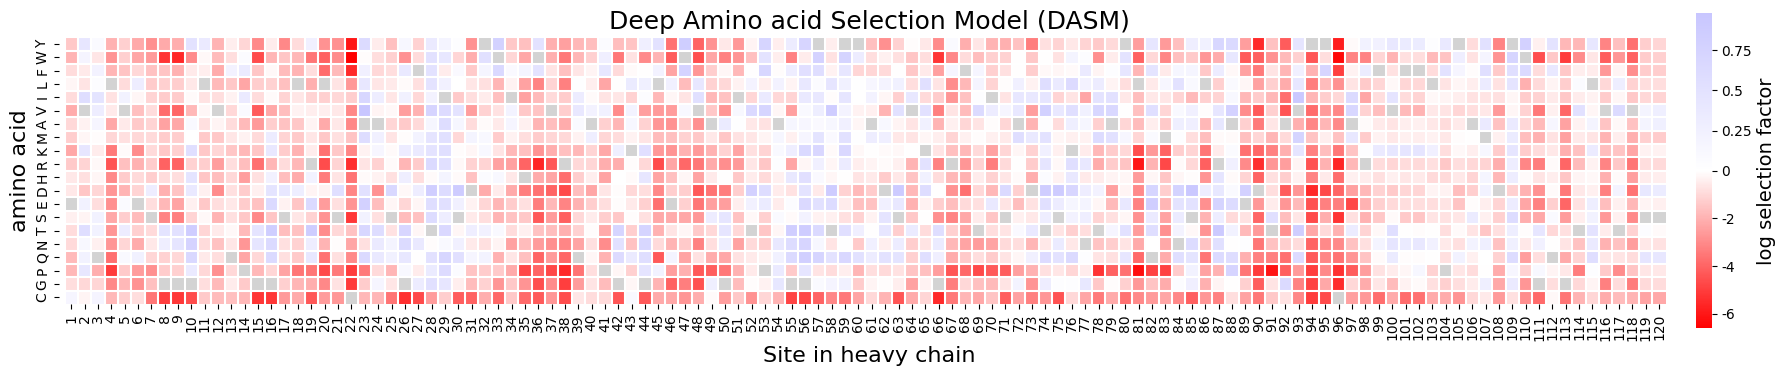

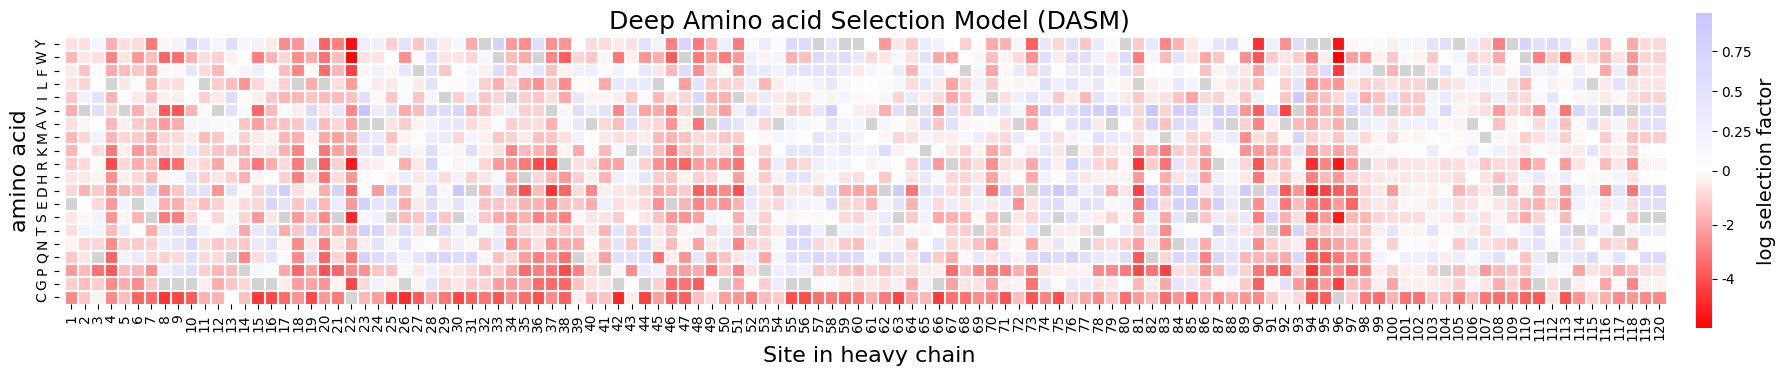

In [6]:
## run the two models on a sample sequence and see that we get similar results

for crepe in [crepe_original, crepe_simulated]:
    [dasm_heavy] = crepe([heavy_wt])
    log_dasm_heavy = (np.log(dasm_heavy).T)
    log_dasm_heavy_df = df_of_arr(log_dasm_heavy)
    assign_wt(log_dasm_heavy_df, heavy_wt, np.nan)

    fig, ax = plt.subplots(1, 1, figsize=(18, 4))

    print(heavy_wt)

    make_heatmap(log_dasm_heavy_df, ax, "log selection factor")
    ax.set_title('Deep Amino acid Selection Model (DASM)', fontsize=18)
    ax.set_xlabel('Site in heavy chain', fontsize=16)
    ax.set_ylabel('amino acid', fontsize=16)
    plt.tight_layout()

## load test dataset and get test sequences

In [7]:
## load test dataset
df_rodriguez = pcp_df_of_nickname('v1rodriguez',)
test_sequences = df_rodriguez.parent_h.to_numpy().copy()
np.random.shuffle(test_sequences)
test_sequences = np.array([translate_sequence(x) for x in test_sequences])


Loading /home/nharel/data/v1/rodriguez-airr-seq-race-prod-InclMutInv_pcp_2024-11-12_MASKED_NI_noN_no-naive.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('sample-igg-SC-18', 440)]
Using cached models: /home/nharel/re/netam/netam/_pretrained/thrifty-0.2.0.zip
Using ThriftyHumV0.2-59 for neutral model on device None


Evaluating model: 100%|██████████| 2176/2176 [00:04<00:00, 461.02it/s]


#### first calculate dropout probability to use so that 95% of predictions fall inside of their appropriate 0.95 CIs - seems to not be statistically helpful but leaving this here just in case

In [8]:
# run MC dropout on test sequences
MC_DROPOUT_ITERATIONS = 100

optimal_dropout = find_optimal_dropout_rate("DASM_TRAINED_MODELS_DIR/dasm_77k-jaffeDasm1SimCC50k-joint", test_sequence_list=test_sequences[:10], mc_dropout_iterations=MC_DROPOUT_ITERATIONS, device='cuda', dropout_prob_start=0.3)


100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


Dropout prob: 0.3, True proportion: 0.984769136772279, Loss: 0.034769136772279


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


Dropout prob: 0.35, True proportion: 0.9731168717814437, Loss: 0.023116871781443726


100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


Dropout prob: 0.39999999999999997, True proportion: 0.9627302086060924, Loss: 0.012730208606092419


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]

Dropout prob: 0.44999999999999996, True proportion: 0.9491140787291612, Loss: -0.000885921270838752
Found dropout prob: 0.45


 ## plot visualizing mc dropout intervals across a single sequence and comparing to non dropout predictions

In [9]:

def plot_confidence_intervals_predictions(real_predictions, mc_dropout_predictions, title=None):
    # Define the specific order for amino acids
    amino_acid_order = list("YWFLIVAMKRHDESTNQPGC")


    all_data_sorted = mc_dropout_predictions.copy()
    # add real predictions to data frame for plotting, and sort data according aa order
    stacked = real_predictions.stack().reset_index()
    stacked.columns = ['AminoAcid', 'Position', 'log_selection_factor']
    stacked['Sample'] = "Original Model"
    all_data_sorted = pd.concat([stacked, all_data_sorted])
    all_data_sorted['AminoAcid_order'] = all_data_sorted['AminoAcid'].map({aa: i for i, aa in enumerate(amino_acid_order)})
    all_data_sorted = all_data_sorted.sort_values('AminoAcid_order')

    # Create a FacetGrid with ordered row parameter
    g = sns.FacetGrid(
        all_data_sorted, 
        row='AminoAcid',
        row_order=amino_acid_order,  # Use the specified order
        height=2.8,
        aspect=10.0,
        sharey=True,
    )

    # Get the actual position categories from your data and ensure they're sorted numerically
    unique_positions = sorted(all_data_sorted['Position'].unique(), key=lambda x: (pd.isna(x), x))

    # Create a color map that assigns the same color to each position
    num_positions = len(unique_positions)
    color_map = dict(zip(unique_positions, sns.color_palette('Set2', num_positions)))

    # Map a boxplot with consistent colors per position and proper handling of NaN values
    def plot_boxes(x, y, **kwargs):
        # Get current data subset
        data = kwargs.get('data')
        
        # Default boxplot - but we'll sort the data first to make sure positions are in correct order
        ax = plt.gca()
        
        # Create a copy of the data and make sure the x variable is treated as category in the correct order
        plot_data = data.copy()
        
        # Define the order explicitly based on our sorted unique_positions
        order = [p for p in unique_positions if not pd.isna(p)]
        
        # Create the boxplot with explicit order
        sns.boxplot(x=x, y=y, data=plot_data[plot_data['Sample'] != 'Original Model'], 
                   ax=ax, order=order, whis=[2.5, 97.5], showfliers=False)
        
        # Now add the points for the original model
        # Get only the original model data for this amino acid
        original_data = plot_data[plot_data['Sample'] == 'Original Model']
        
        # For each position, map it to the correct x-coordinate
        for pos in original_data['Position'].unique():
            if pos in order:
                pos_idx = order.index(pos)  # Get the index in the order list
                
                # Get the y-value for this position
                y_val = original_data[original_data['Position'] == pos]['log_selection_factor'].values
                
                if len(y_val) > 0:
                    # Plot a point at the correct position
                    ax.scatter([pos_idx], y_val, color='red', s=80, marker='^', zorder=10)

    # Apply the custom plotting function
    g.map_dataframe(plot_boxes, 'Position', 'log_selection_factor')

    # Set y-limits for all subplots
    g.set(ylim=(-10, all_data_sorted.log_selection_factor.max() + 0.1))

    # Add a horizontal line at y=0 to all facets
    g.map(plt.axhline, y=0, ls='-', c='red')

    # Customize x-ticks to match the categorical positions
    for i, ax in enumerate(g.axes.flat):
        # Filter out NaN positions for x-ticks
        valid_positions = [p for p in unique_positions if not pd.isna(p)]
        ax.set_xticks(range(len(valid_positions)))
        ax.set_xticklabels(valid_positions, rotation=90, fontsize=12)
        ax.xaxis.set_tick_params(labelbottom=True)
        
        # Add title on the left side of each plot
        if i < len(amino_acid_order):
            current_aa = amino_acid_order[i]
            # Remove any existing title
            ax.set_title("")
            # Add text at the left side
            ax.text(-0.05, 0.5, current_aa, transform=ax.transAxes, 
                    ha='right', va='center', fontsize=18, fontweight='bold')

    # Add a SHARED y-axis label for all subplots (on the left side)
    g.fig.text(0.01, 0.5, 'Log DASM Selection Factor', va='center', rotation='vertical', fontsize=16)

    # Remove individual y-axis labels (since we added a shared one)
    g.set_axis_labels('Position', '', fontsize=16)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10, label='Original Model'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='steelblue', markersize=10, label='MC Dropout on simulated-data model')
    ]
    g.fig.legend(handles=legend_elements, loc='upper right')

    # Set the main title for the entire figure
    if title:
        g.fig.suptitle(title, fontsize=20, fontweight='bold')
        
    # Adjust layout to make room for the labels and titles
    #plt.tight_layout()
    g.fig.subplots_adjust(left=0.08, bottom=0.15, right=0.95, top=0.95)  # Add space for labels

    plt.show()

In [10]:
MC_DROPOUT_ITERATIONS = 100
seq = test_sequences[0]


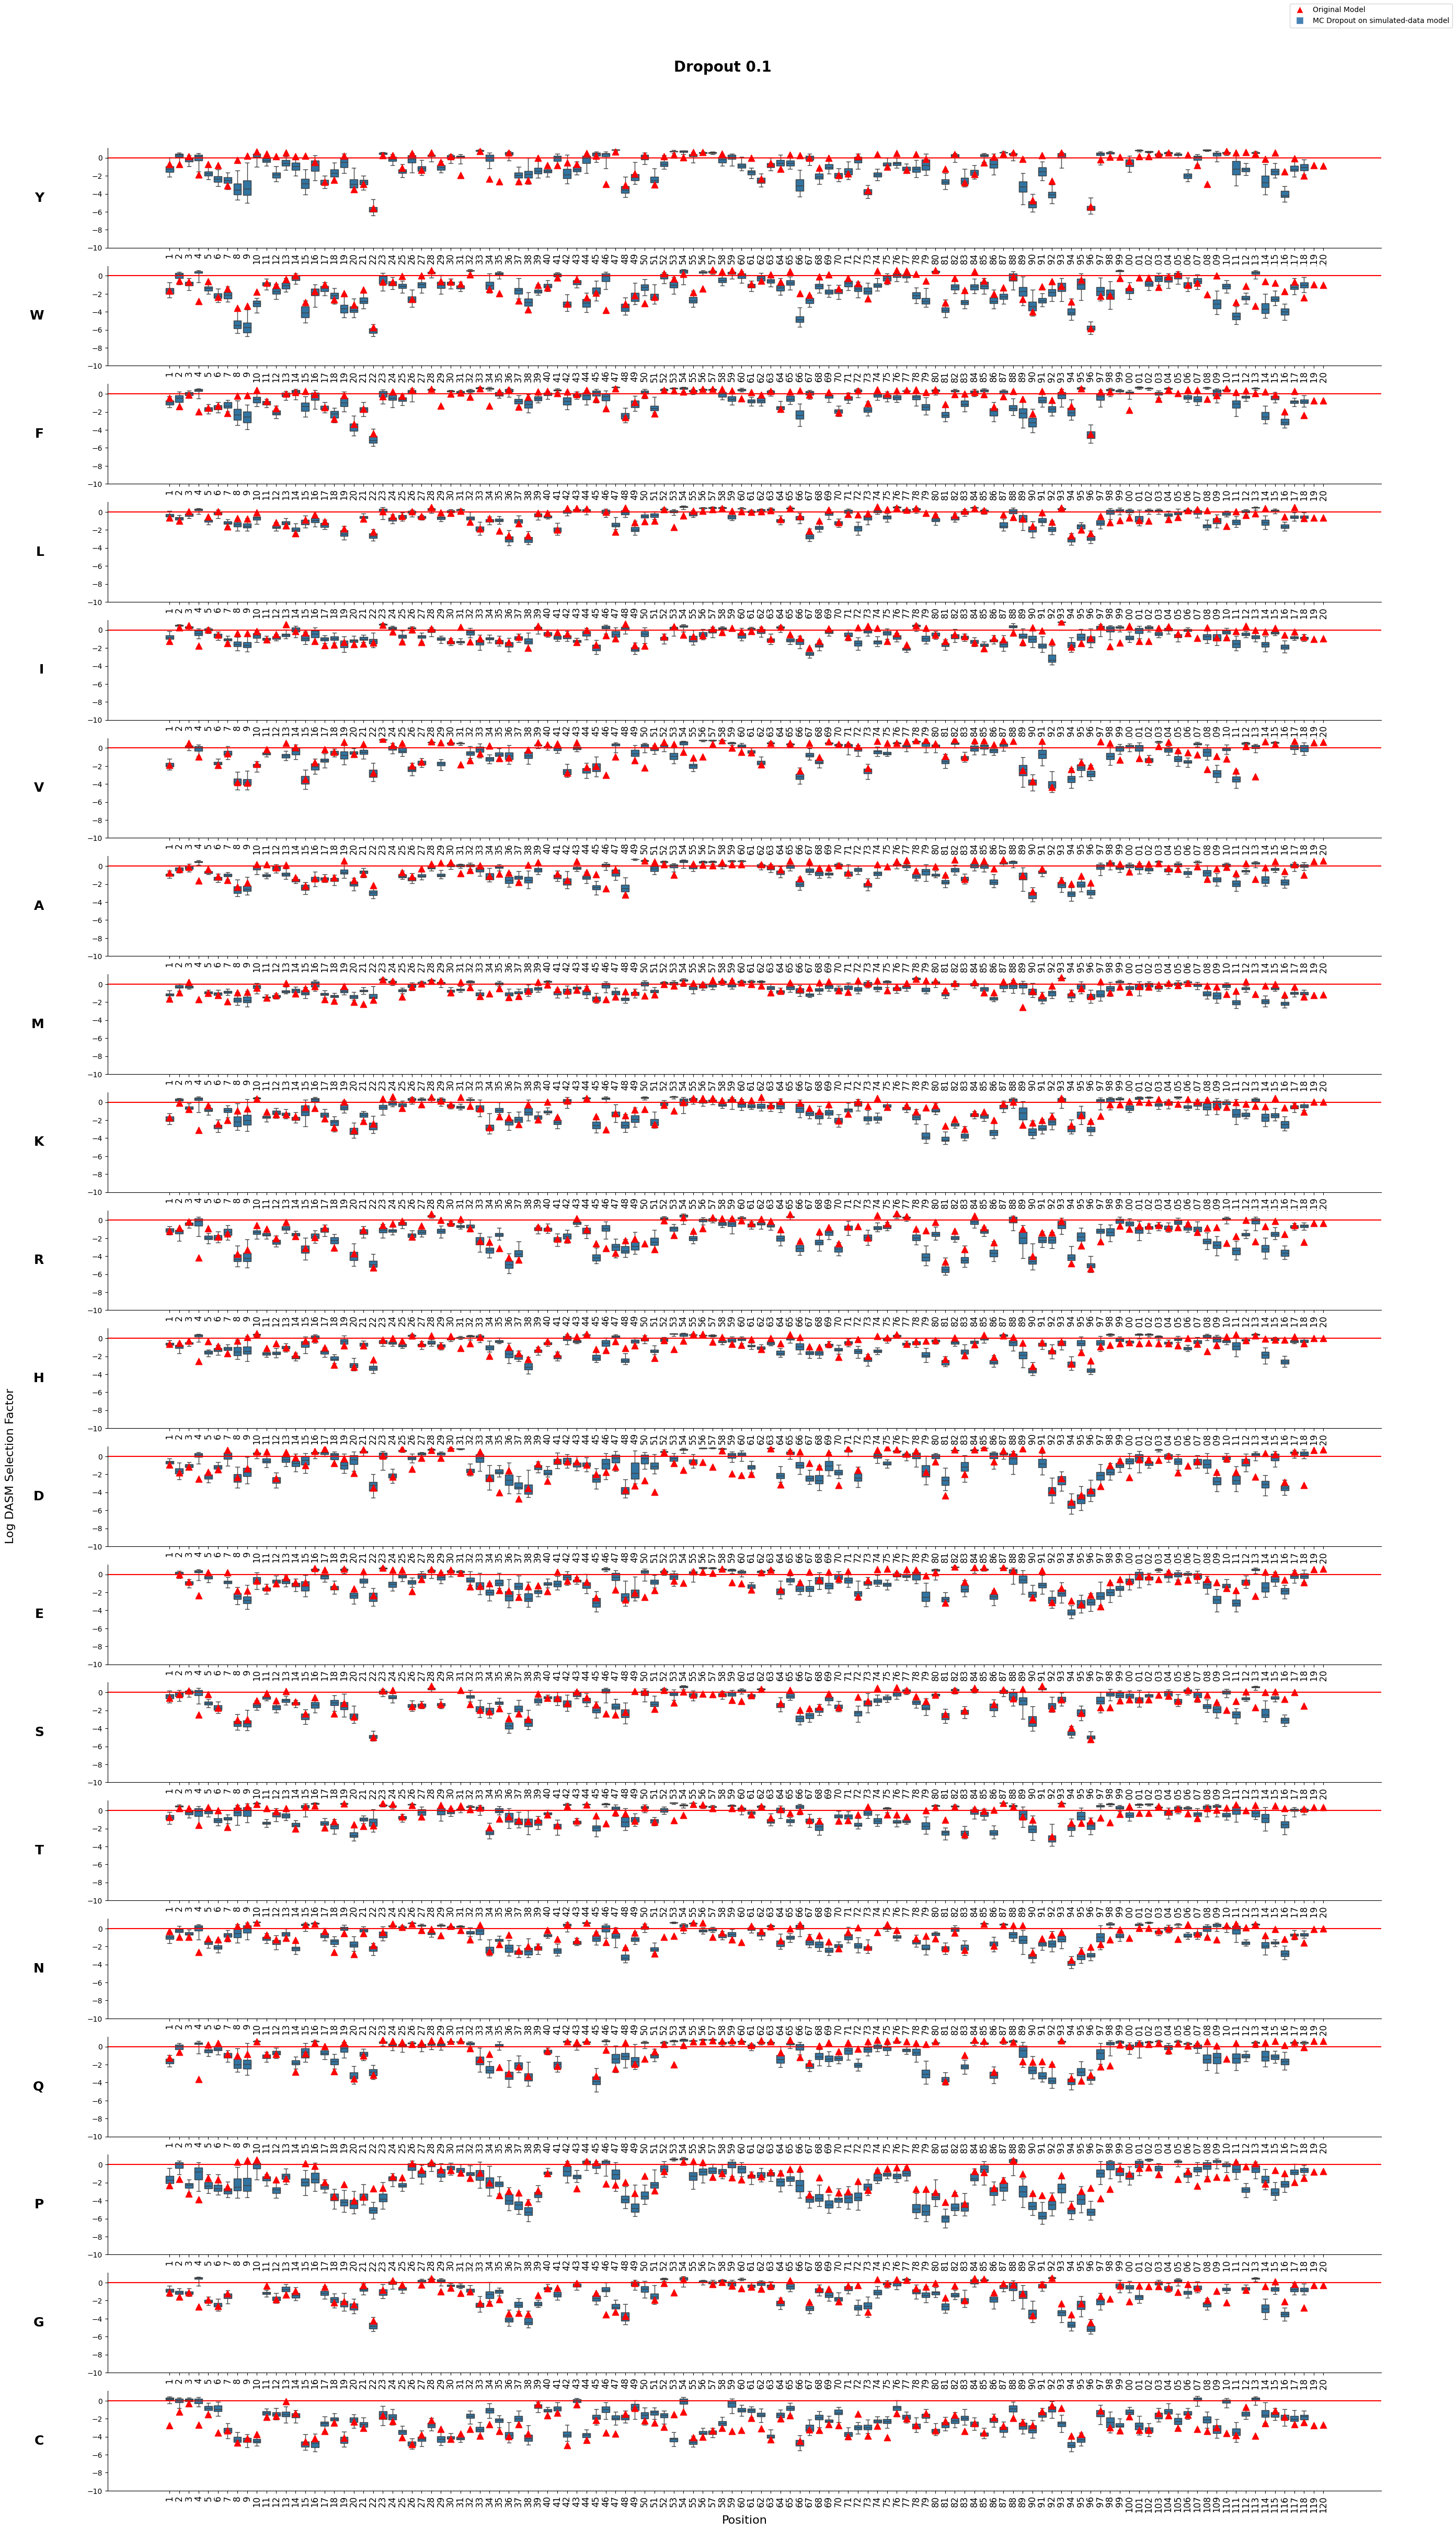

In [11]:
## visaulize predictions of the ground truth model together with drop out distributions on the same model
# # dropout 0.1 - low

all_data = run_mc_dropout_on_heavy_seq(seq, model_path="DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", device='cuda', dropout_prob=0.1, mc_dropout_iterations=MC_DROPOUT_ITERATIONS)
plot_confidence_intervals_predictions(log_dasm_heavy_df, all_data, title='Dropout 0.1')

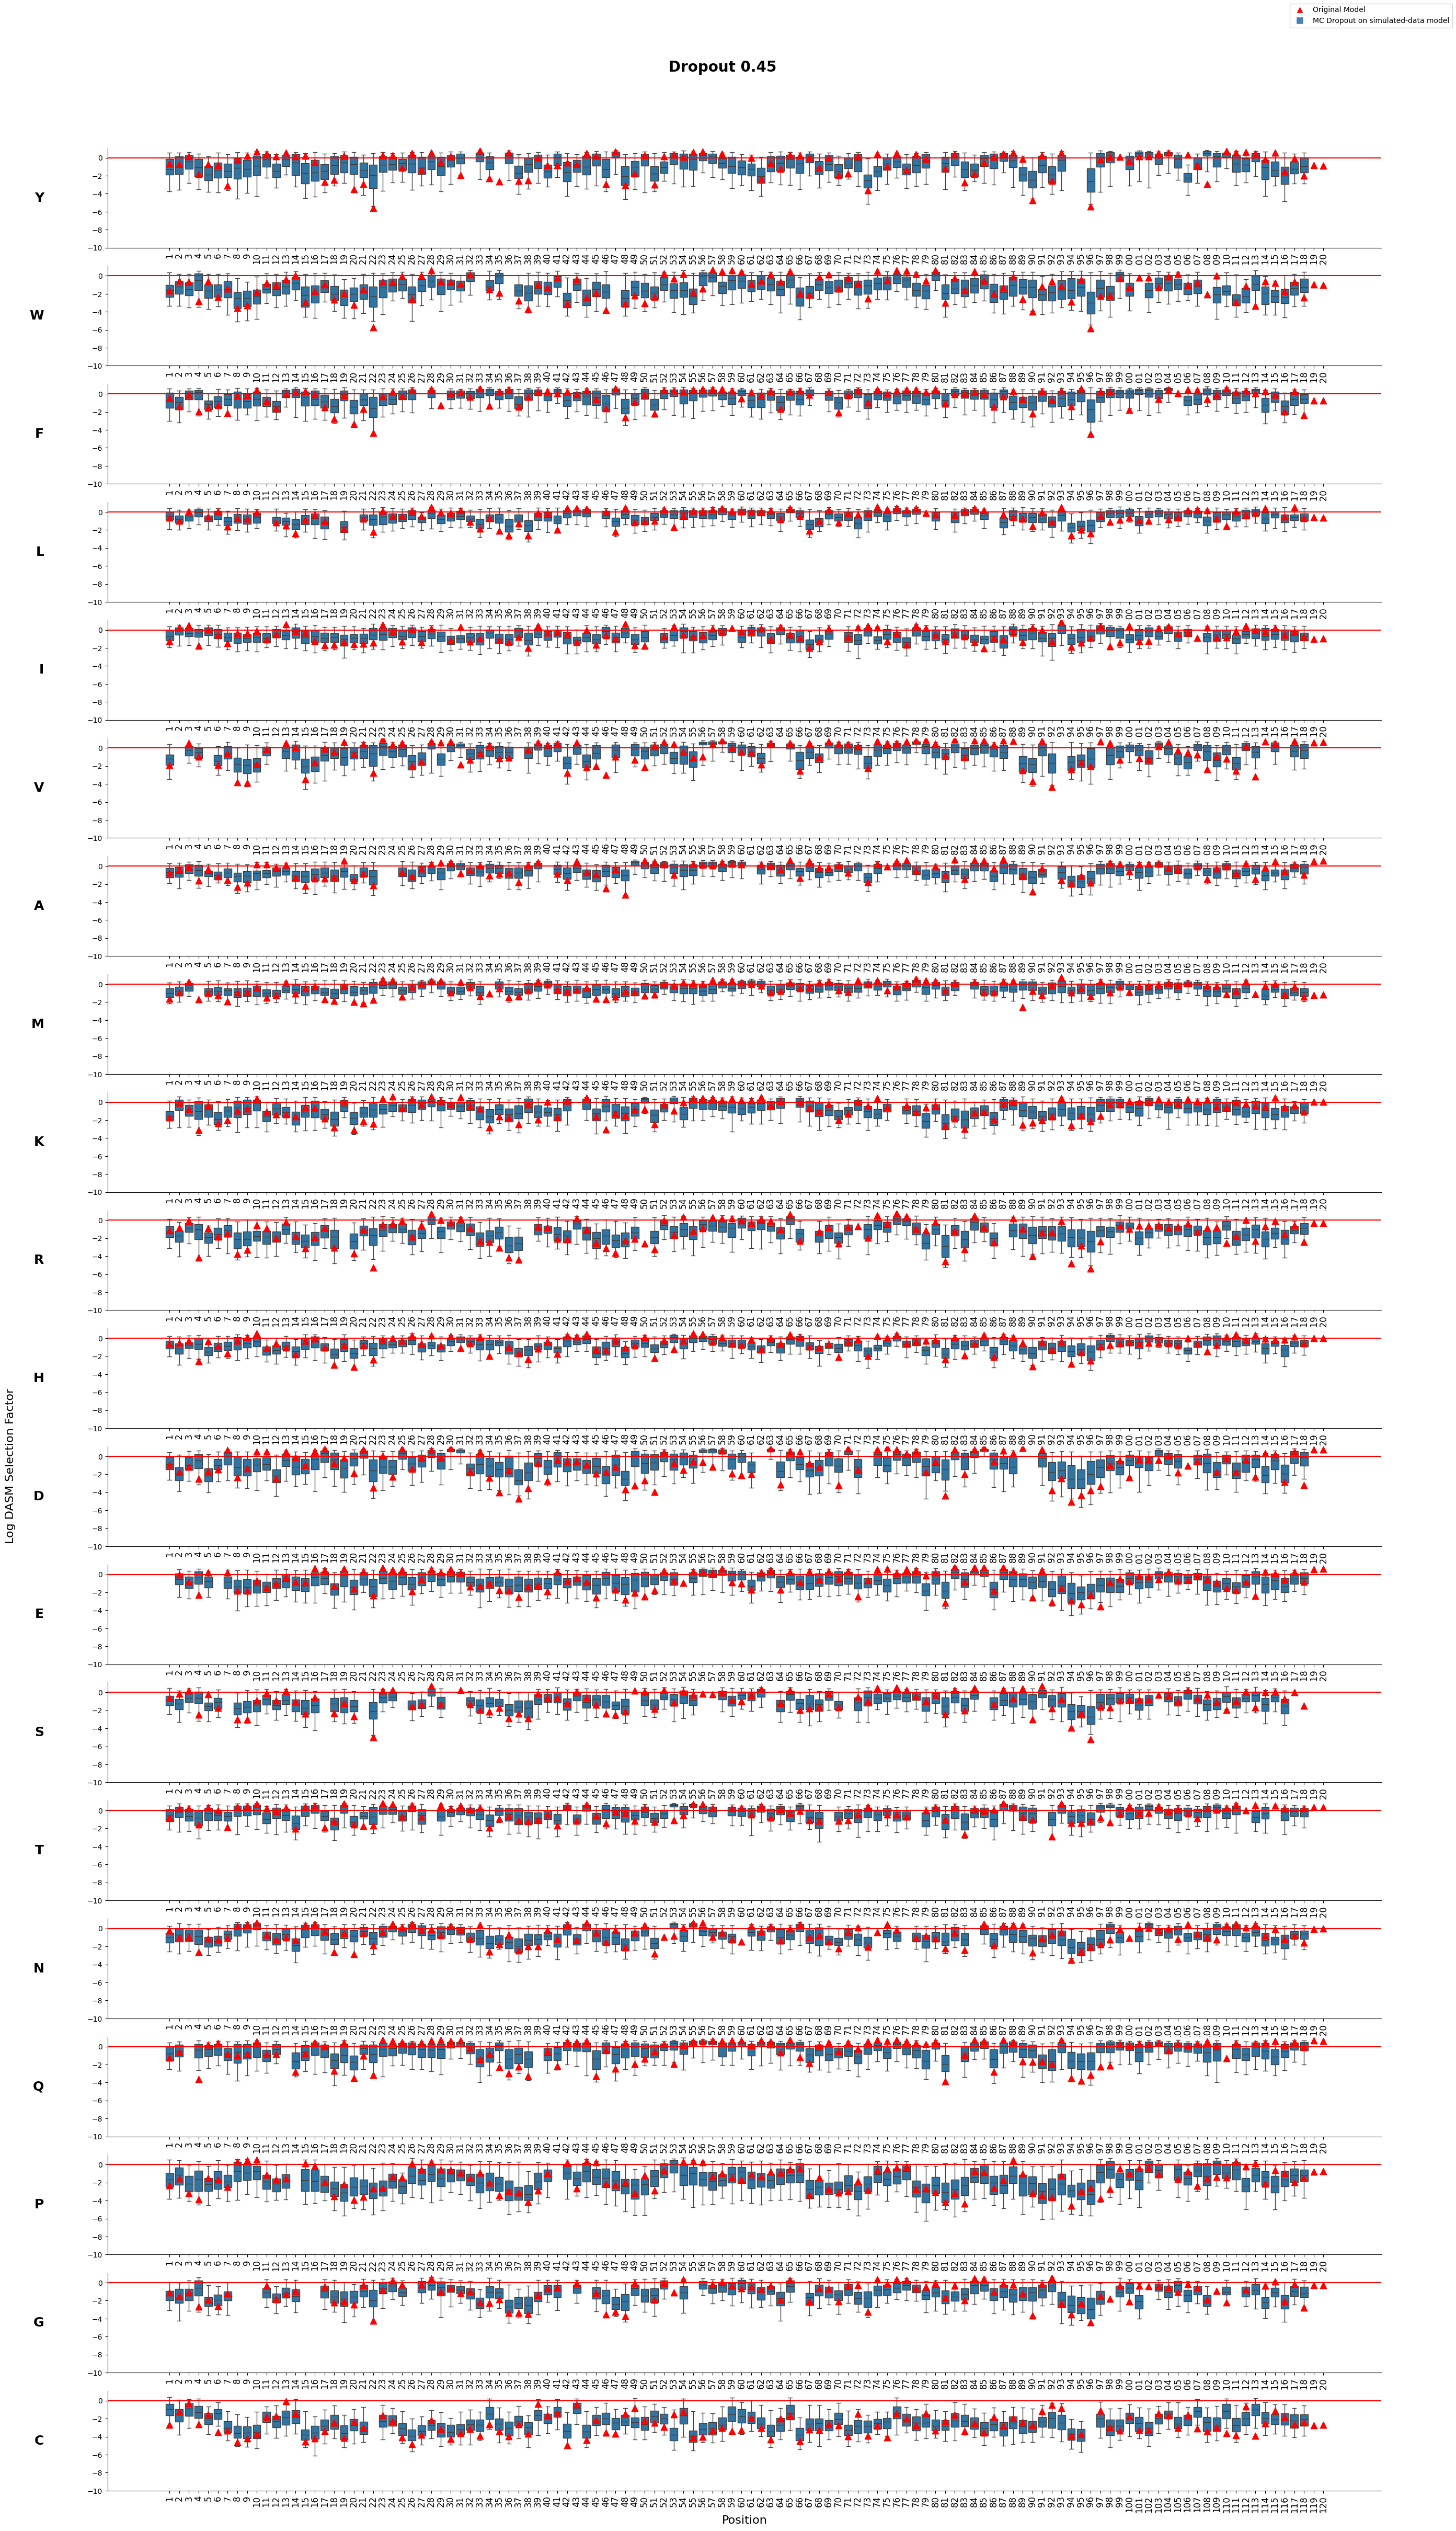

In [12]:
## visaulize predictions of the ground truth model together with drop out distributions on the same model
# # dropout 0.45 - moderate dropout

all_data = run_mc_dropout_on_heavy_seq(seq, model_path="DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", device='cuda', dropout_prob=0.45, mc_dropout_iterations=MC_DROPOUT_ITERATIONS)
plot_confidence_intervals_predictions(log_dasm_heavy_df, all_data, title='Dropout 0.45')

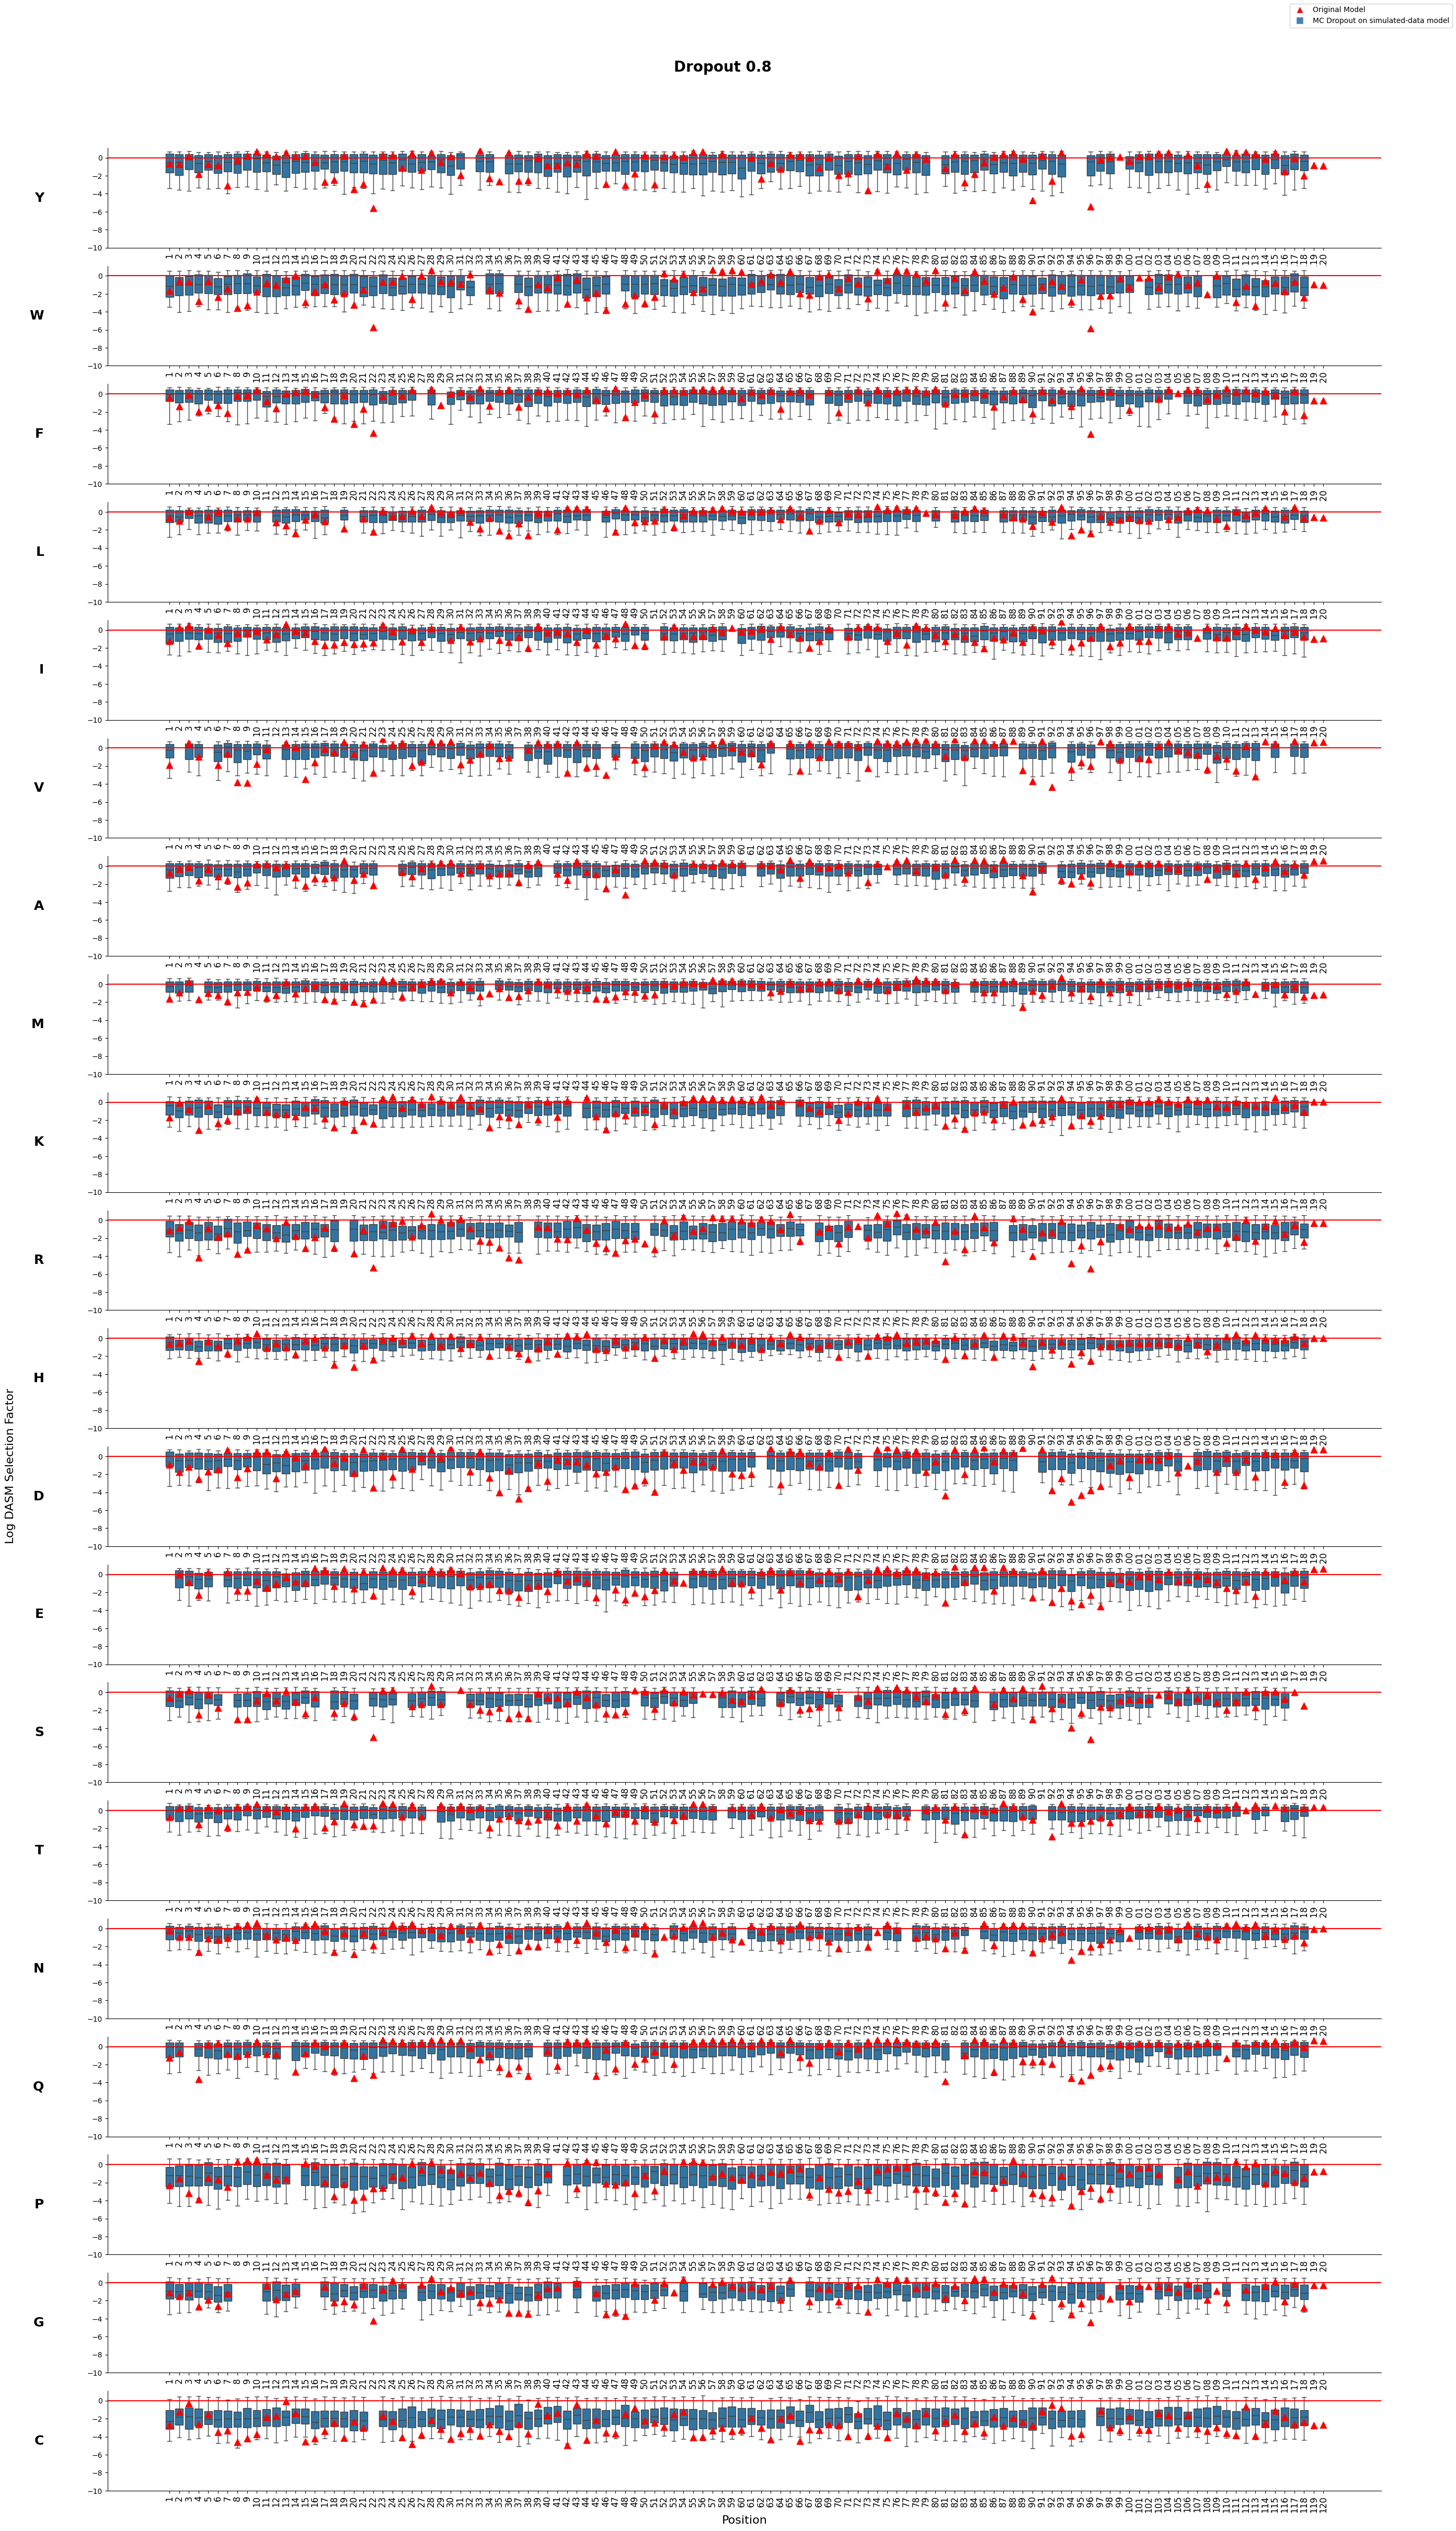

In [13]:
## visaulize predictions of the ground truth model together with drop out distributions on the same model
# # dropout 0.8 - high

all_data = run_mc_dropout_on_heavy_seq(seq, model_path="DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", device='cuda', dropout_prob=0.8, mc_dropout_iterations=MC_DROPOUT_ITERATIONS)
plot_confidence_intervals_predictions(log_dasm_heavy_df, all_data, title='Dropout 0.8')

## comparison of the ground truth predictions to CI intervals from MC dropout in model trained on simulations

file exists, skipping


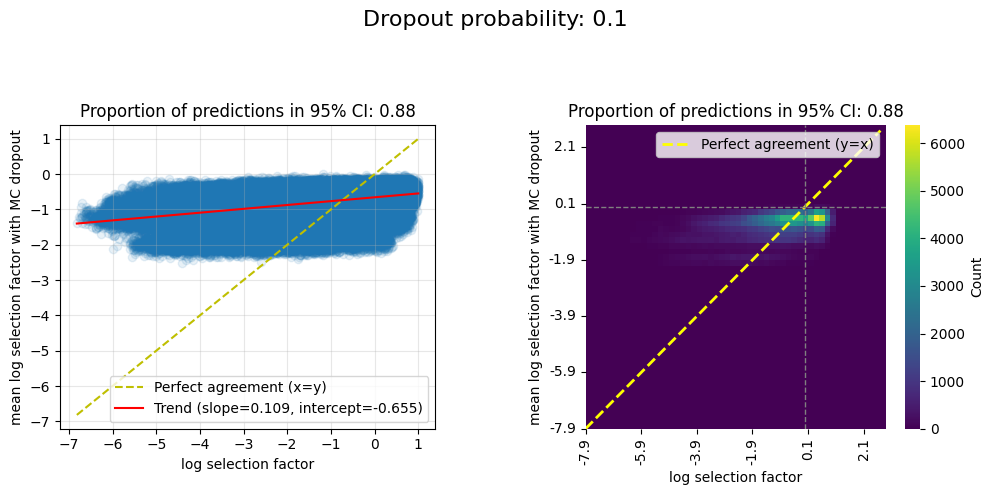

In [14]:

NUMBER_OF_SEQUENCES = 100
OUTPUT_PATH = localify("DATA_DIR/uncertainty/simulation_data_uncertainty/dasm_mc_dropout_stats_prob0.1.csv")

if os.path.exists(OUTPUT_PATH):
    print('file exists, skipping')  
    stats_df = pd.read_csv(OUTPUT_PATH)
else:
    stats_df = compare_models_w_mc_dropout("DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", "DASM_TRAINED_MODELS_DIR/dasm_77k-jaffeDasm1SimCC50k-joint", test_sequences[:NUMBER_OF_SEQUENCES], mc_dropout_iterations=MC_DROPOUT_ITERATIONS, dropout_prob=0.1, device='cuda')
    stats_df.to_csv(OUTPUT_PATH, index=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
axes = ax.flatten()
plot_compare_models_w_mc_dropout_prediction_scatter(stats_df, axes[0], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(stats_df, axes[1], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
fig.suptitle('Dropout probability: 0.1\n\n', fontsize=16)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.75)
#fig.tight_layout()


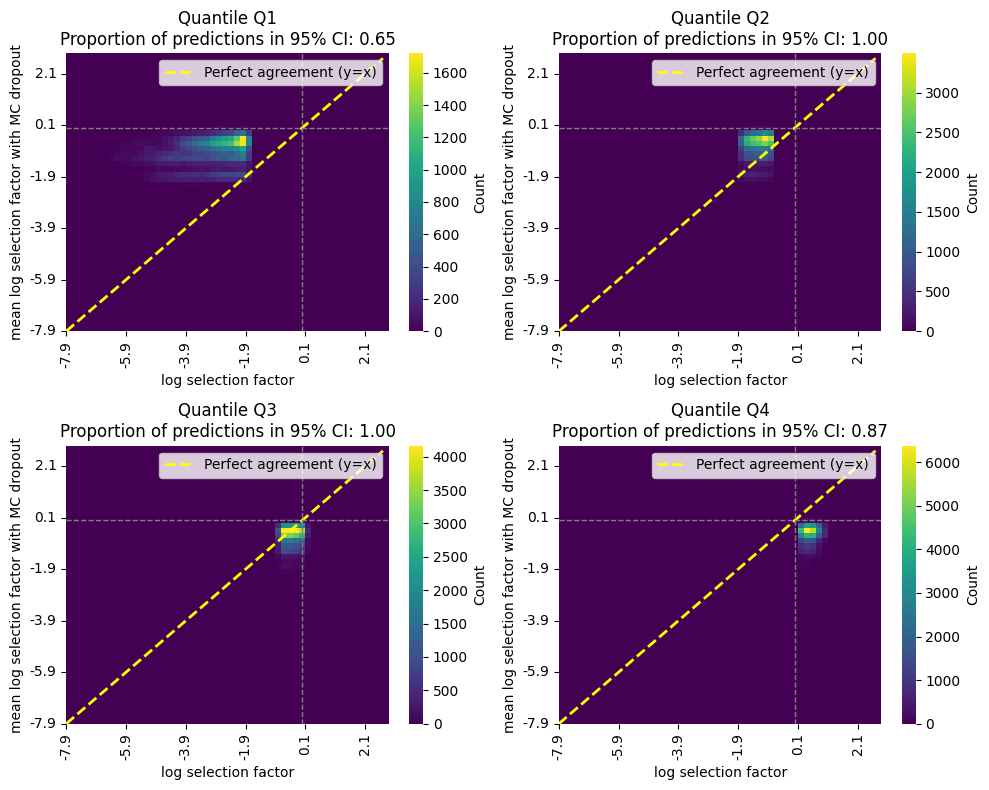

In [15]:
## check how the fit is across the quantiles of the DASM log selection factor

# First, create quantiles based on DASM_log_selection_factor
stats_df['quantile'] = pd.qcut(stats_df['DASM_log_selection_factor'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Create a figure with 2x2 subplots for the 4 quantiles
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # Flatten the 2x2 array to make it easier to iterate

# For each quantile, filter the data and plot
for i, quantile in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    # Filter data for this quantile
    quantile_df = stats_df[stats_df['quantile'] == quantile]
    
    # Plot for this quantile
    plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(
        quantile_df, 
        axes[i], 
        title=f'Quantile {quantile}',
        x_label='log selection factor', 
        y_label='mean log selection factor with MC dropout'
    )

plt.tight_layout()
plt.show()

file exists, skipping


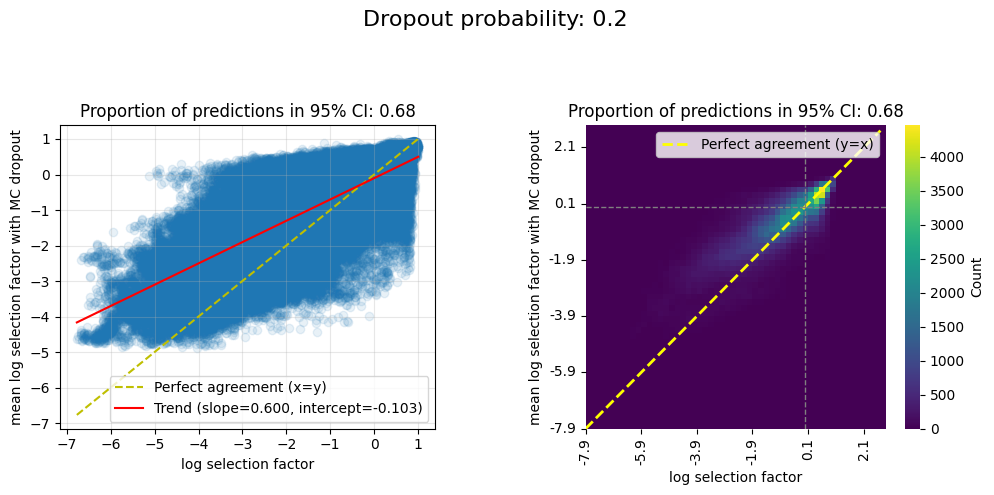

In [16]:

NUMBER_OF_SEQUENCES = 100
OUTPUT_PATH = localify("DATA_DIR/uncertainty/simulation_data_uncertainty/dasm_mc_dropout_stats_prob0.2.csv")


if os.path.exists(OUTPUT_PATH):
    print('file exists, skipping')  
    stats_df = pd.read_csv(OUTPUT_PATH)
else:
    stats_df = compare_models_w_mc_dropout("DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", "DASM_TRAINED_MODELS_DIR/dasm_77k-jaffeDasm1SimCC50k-joint", test_sequences[:NUMBER_OF_SEQUENCES], mc_dropout_iterations=MC_DROPOUT_ITERATIONS, dropout_prob=0.2, device='cuda')
    stats_df.to_csv(OUTPUT_PATH, index=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
axes = ax.flatten()
plot_compare_models_w_mc_dropout_prediction_scatter(stats_df, axes[0], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(stats_df, axes[1], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
fig.suptitle('Dropout probability: 0.2\n\n', fontsize=16)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.75)
#fig.tight_layout()


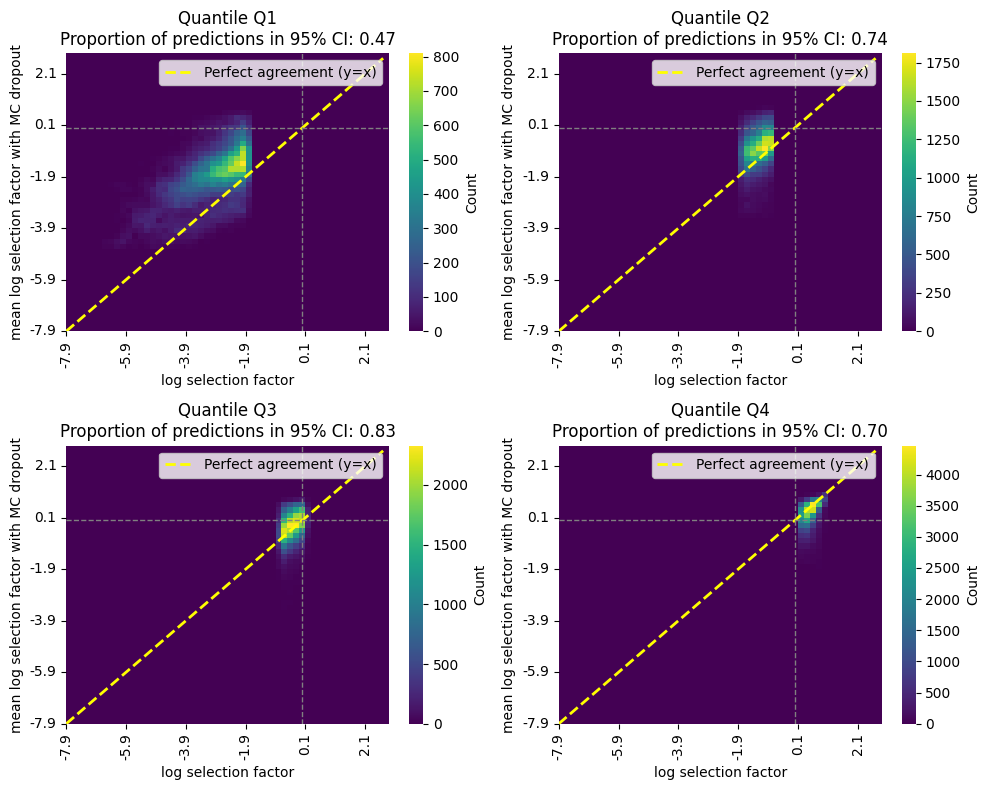

In [17]:
## check how the fit is across the quantiles of the DASM log selection factor

# First, create quantiles based on DASM_log_selection_factor
stats_df['quantile'] = pd.qcut(stats_df['DASM_log_selection_factor'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Create a figure with 2x2 subplots for the 4 quantiles
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # Flatten the 2x2 array to make it easier to iterate

# For each quantile, filter the data and plot
for i, quantile in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    # Filter data for this quantile
    quantile_df = stats_df[stats_df['quantile'] == quantile]
    
    # Plot for this quantile
    plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(
        quantile_df, 
        axes[i], 
        title=f'Quantile {quantile}',
        x_label='log selection factor', 
        y_label='mean log selection factor with MC dropout'
    )

plt.tight_layout()
plt.show()

file exists, skipping


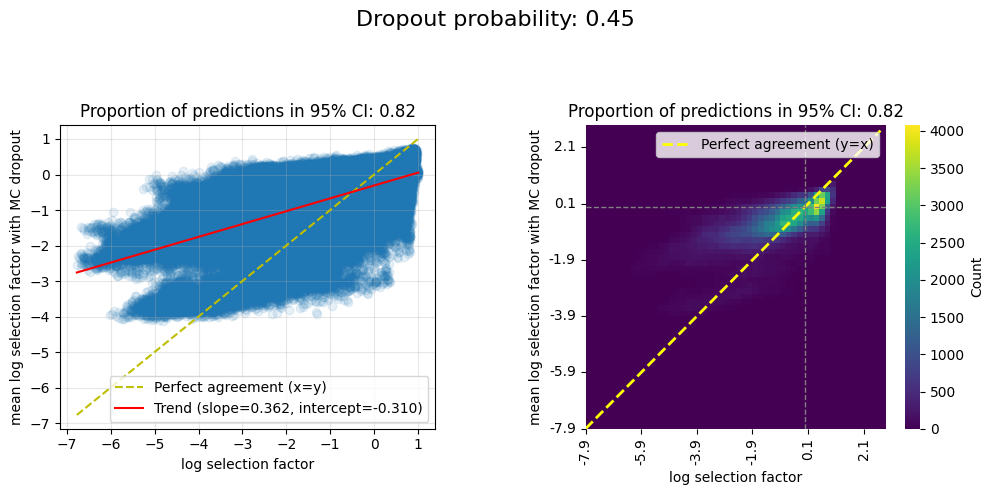

In [18]:

NUMBER_OF_SEQUENCES = 100
OUTPUT_PATH = localify("DATA_DIR/uncertainty/simulation_data_uncertainty/dasm_mc_dropout_stats_prob0.45.csv")


if os.path.exists(OUTPUT_PATH):
    print('file exists, skipping')  
    stats_df = pd.read_csv(OUTPUT_PATH)
else:
    stats_df = compare_models_w_mc_dropout("DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", "DASM_TRAINED_MODELS_DIR/dasm_77k-jaffeDasm1SimCC50k-joint", test_sequences[:NUMBER_OF_SEQUENCES], mc_dropout_iterations=MC_DROPOUT_ITERATIONS, dropout_prob=0.45, device='cuda')
    stats_df.to_csv(OUTPUT_PATH, index=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
axes = ax.flatten()
plot_compare_models_w_mc_dropout_prediction_scatter(stats_df, axes[0], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(stats_df, axes[1], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
fig.suptitle('Dropout probability: 0.45\n\n', fontsize=16)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.75)
#fig.tight_layout()


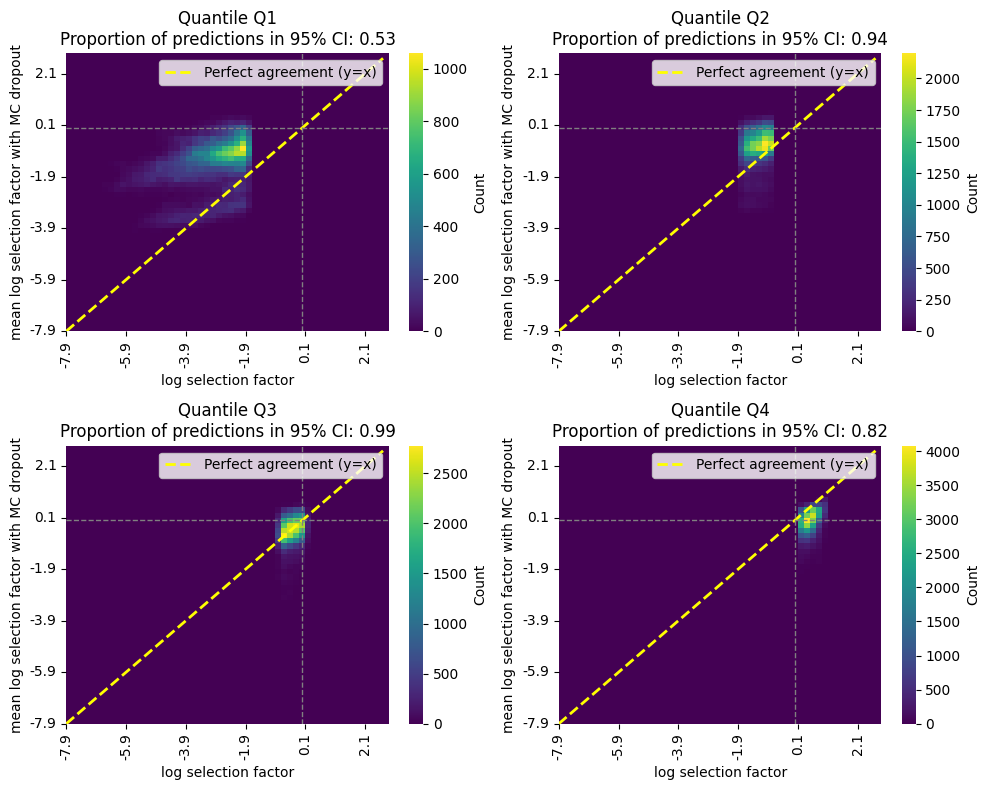

In [19]:
## check how the fit is across the quantiles of the DASM log selection factor

# First, create quantiles based on DASM_log_selection_factor
stats_df['quantile'] = pd.qcut(stats_df['DASM_log_selection_factor'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Create a figure with 2x2 subplots for the 4 quantiles
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # Flatten the 2x2 array to make it easier to iterate

# For each quantile, filter the data and plot
for i, quantile in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    # Filter data for this quantile
    quantile_df = stats_df[stats_df['quantile'] == quantile]
    
    # Plot for this quantile
    plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(
        quantile_df, 
        axes[i], 
        title=f'Quantile {quantile}',
        x_label='log selection factor', 
        y_label='mean log selection factor with MC dropout'
    )

plt.tight_layout()
plt.show()

## For comparison, compare the ground truth model confidence intervals on its own dropout CIs

file exists, skipping


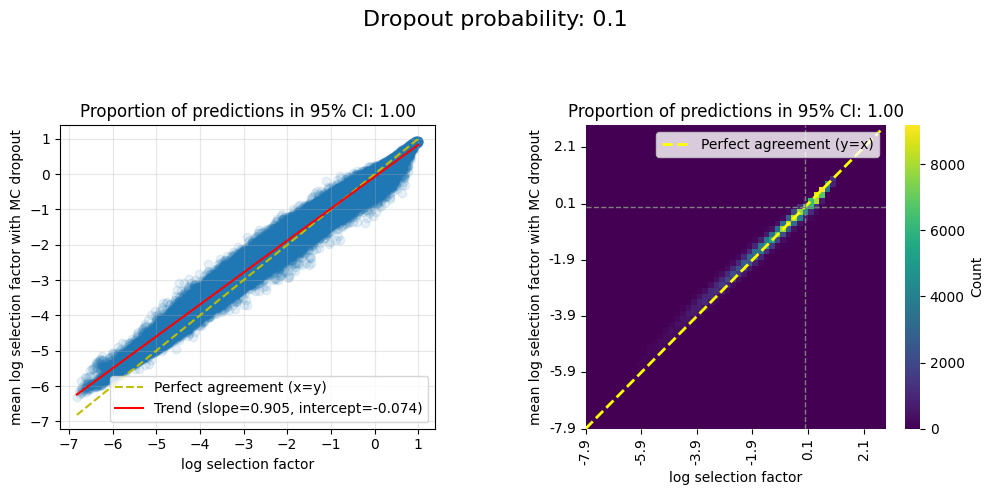

In [20]:
## for comparison, what would comparing the origianl model to the origianl model look like?
# dropout 0.1

NUMBER_OF_SEQUENCES = 100
OUTPUT_PATH = localify("DATA_DIR/uncertainty/simulation_data_uncertainty/dasm_mc_dropout_stats_compare_model_to_itself_dropout0.1.csv")



if os.path.exists(OUTPUT_PATH):
    print('file exists, skipping')  
    stats_df = pd.read_csv(OUTPUT_PATH)
else:
    stats_df = compare_models_w_mc_dropout("DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", "DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", test_sequences[:NUMBER_OF_SEQUENCES], mc_dropout_iterations=MC_DROPOUT_ITERATIONS, dropout_prob=0.1, device='cuda')
    stats_df.to_csv(OUTPUT_PATH, index=False)


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
axes = ax.flatten()
plot_compare_models_w_mc_dropout_prediction_scatter(stats_df, axes[0], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(stats_df, axes[1], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
fig.suptitle('Dropout probability: 0.1\n\n', fontsize=16)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.75)
#fig.tight_layout()


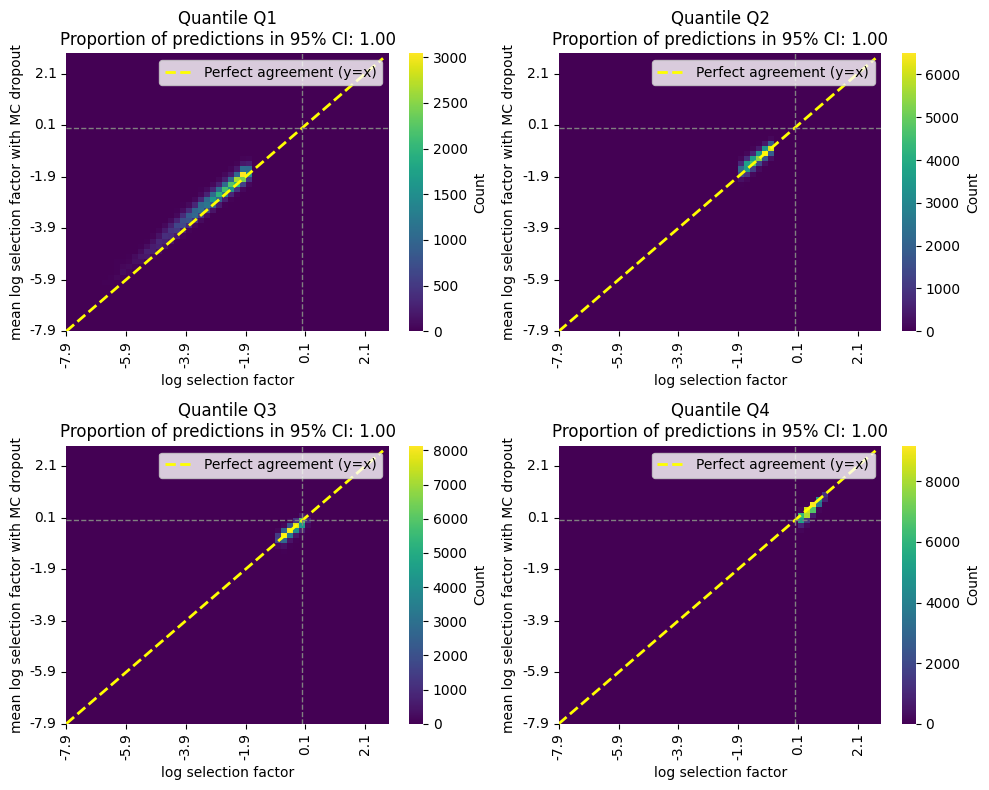

In [21]:
## check how the fit is across the quantiles of the DASM log selection factor

# First, create quantiles based on DASM_log_selection_factor
stats_df['quantile'] = pd.qcut(stats_df['DASM_log_selection_factor'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Create a figure with 2x2 subplots for the 4 quantiles
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # Flatten the 2x2 array to make it easier to iterate

# For each quantile, filter the data and plot
for i, quantile in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    # Filter data for this quantile
    quantile_df = stats_df[stats_df['quantile'] == quantile]
    
    # Plot for this quantile
    plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(
        quantile_df, 
        axes[i], 
        title=f'Quantile {quantile}',
        x_label='log selection factor', 
        y_label='mean log selection factor with MC dropout'
    )

plt.tight_layout()
plt.show()

file exists, skipping


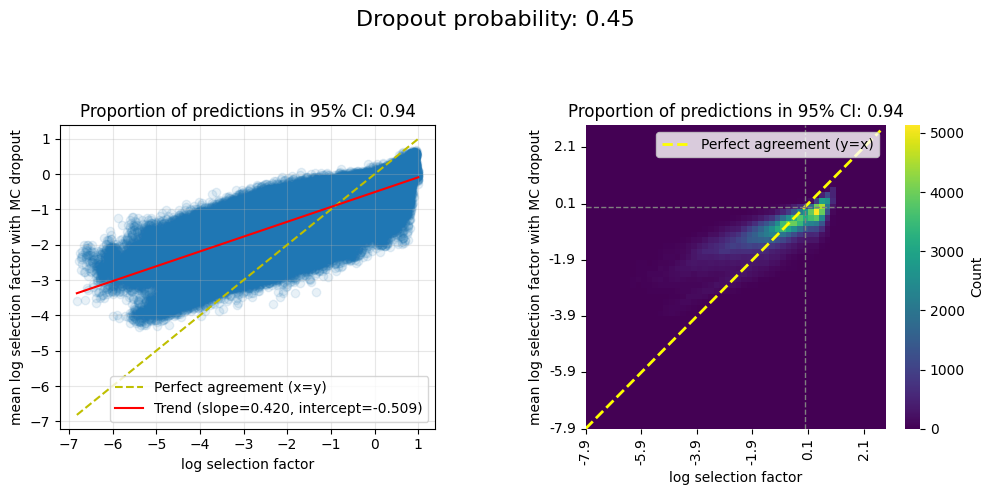

In [22]:
## for comparison, what would comparing the origianl model to the origianl model look like?
# dropout 0.45


NUMBER_OF_SEQUENCES = 100
OUTPUT_PATH = localify("DATA_DIR/uncertainty/simulation_data_uncertainty/dasm_mc_dropout_stats_compare_model_to_itself_dropout0.45.csv")


if os.path.exists(OUTPUT_PATH):
    print('file exists, skipping')  
    stats_df = pd.read_csv(OUTPUT_PATH)
else:
    stats_df = compare_models_w_mc_dropout("DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", "DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", test_sequences[:NUMBER_OF_SEQUENCES], mc_dropout_iterations=MC_DROPOUT_ITERATIONS, dropout_prob=optimal_dropout, device='cuda')
    stats_df.to_csv(OUTPUT_PATH, index=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
axes = ax.flatten()
plot_compare_models_w_mc_dropout_prediction_scatter(stats_df, axes[0], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(stats_df, axes[1], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
fig.suptitle('Dropout probability: 0.45\n\n', fontsize=16)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.75)
#fig.tight_layout()

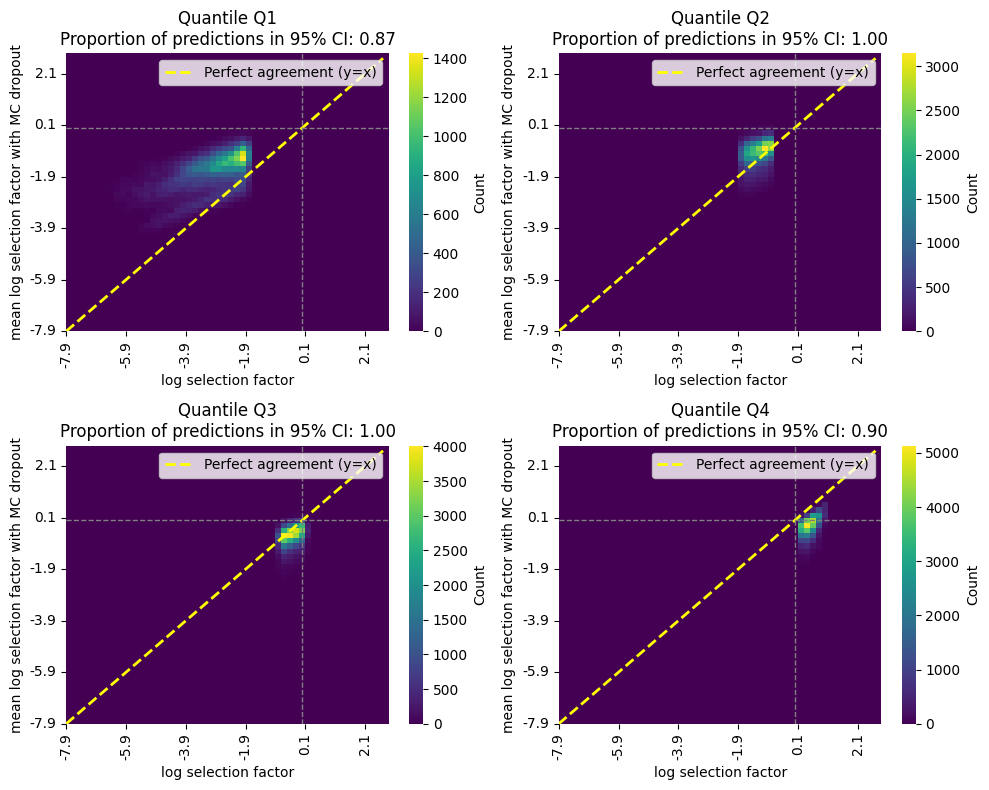

In [23]:
## check how the fit is across the quantiles of the DASM log selection factor

# First, create quantiles based on DASM_log_selection_factor
stats_df['quantile'] = pd.qcut(stats_df['DASM_log_selection_factor'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Create a figure with 2x2 subplots for the 4 quantiles
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()  # Flatten the 2x2 array to make it easier to iterate

# For each quantile, filter the data and plot
for i, quantile in enumerate(['Q1', 'Q2', 'Q3', 'Q4']):
    # Filter data for this quantile
    quantile_df = stats_df[stats_df['quantile'] == quantile]
    
    # Plot for this quantile
    plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(
        quantile_df, 
        axes[i], 
        title=f'Quantile {quantile}',
        x_label='log selection factor', 
        y_label='mean log selection factor with MC dropout'
    )

plt.tight_layout()
plt.show()

file exists, skipping


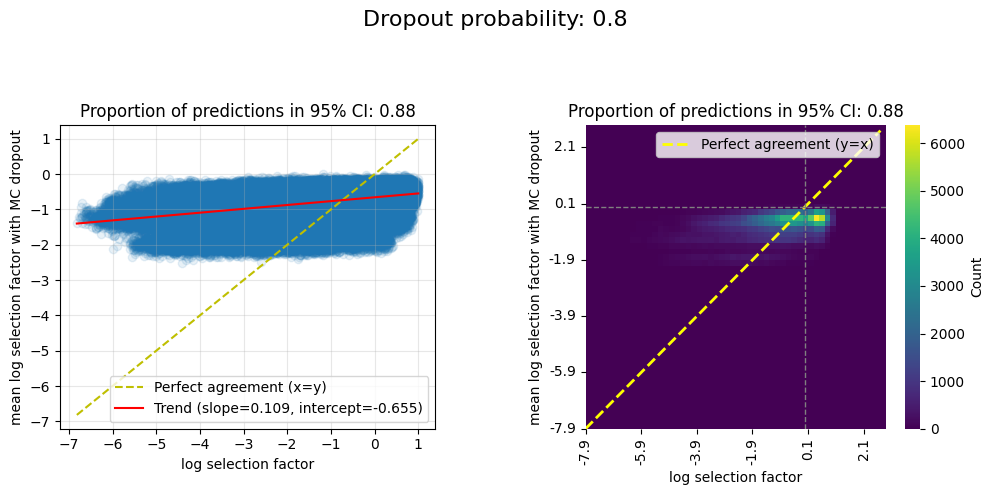

In [24]:
## for comparison, what would comparing the origianl model to the origianl model look like?
# dropout 0.8

NUMBER_OF_SEQUENCES = 100
OUTPUT_PATH = localify("DATA_DIR/uncertainty/simulation_data_uncertainty/dasm_mc_dropout_stats_compare_model_to_itself_dropout0.8.csv")


if os.path.exists(OUTPUT_PATH):
    print('file exists, skipping')  
    stats_df = pd.read_csv(OUTPUT_PATH)
else:
    stats_df = compare_models_w_mc_dropout("DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", "DASM_TRAINED_MODELS_DIR/dasm_77k-v1jaffeCC50k-joint", test_sequences[:NUMBER_OF_SEQUENCES], mc_dropout_iterations=MC_DROPOUT_ITERATIONS, dropout_prob=0.8, device='cuda')
    stats_df.to_csv(OUTPUT_PATH, index=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
axes = ax.flatten()
plot_compare_models_w_mc_dropout_prediction_scatter(stats_df, axes[0], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(stats_df, axes[1], title='', x_label='log selection factor', y_label='mean log selection factor with MC dropout')
fig.suptitle('Dropout probability: 0.8\n\n', fontsize=16)
plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.75)
#fig.tight_layout()


### examine distribution of the differences between the two models (0.1 dropout)

In [25]:
stats_df.to_csv(localify("DATA_DIR/uncertainty/simulation_data_uncertainty/dasm_mc_dropout_stats_prob0.1.csv"), index=False)
stats_df['flipped_signs'] = ((stats_df['lower_bound_log_selection_factor'] > 0) & (stats_df['upper_bound_log_selection_factor'] > 0) & (stats_df['DASM_log_selection_factor'] < 0))|((stats_df['lower_bound_log_selection_factor'] < 0) & (stats_df['upper_bound_log_selection_factor'] < 0) & (stats_df['DASM_log_selection_factor'] > 0))


<Figure size 1000x400 with 0 Axes>

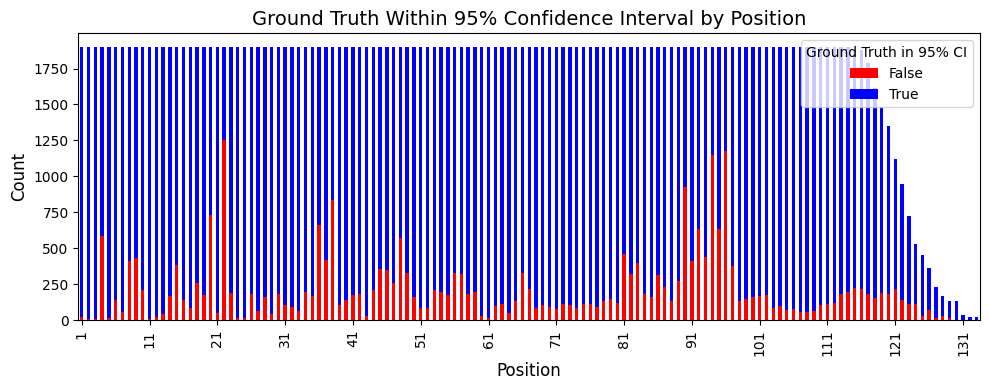

In [26]:
plt.figure(figsize=(10, 4))

# Get count data by position and ground_truth_in_0.95_range
count_data = stats_df.groupby(['Position', 'ground_truth_in_0.95_range']).size().unstack(fill_value=0)

# Ensure both True and False categories exist
if True not in count_data.columns:
    count_data[True] = 0
if False not in count_data.columns:
    count_data[False] = 0

# Create stacked bar plot
ax = count_data.plot(kind='bar', stacked=True, figsize=(10, 4), 
                    color=['red', 'blue'])  # False, True

# Customize the plot
plt.xlabel('Position', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Ground Truth Within 95% Confidence Interval by Position', fontsize=14)

# Get all tick positions
positions = ax.get_xticks()
labels = [item.get_text() for item in ax.get_xticklabels()]

# Keep only every 10th tick and label
indices_to_keep = [i for i, position in enumerate(positions) if i % 10 == 0]
positions_to_keep = [positions[i] for i in indices_to_keep]
labels_to_keep = [labels[i] for i in indices_to_keep]

# Set the new ticks and labels
ax.set_xticks(positions_to_keep)
ax.set_xticklabels(labels_to_keep, rotation=90)

plt.legend(title='Ground Truth in 95% CI')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

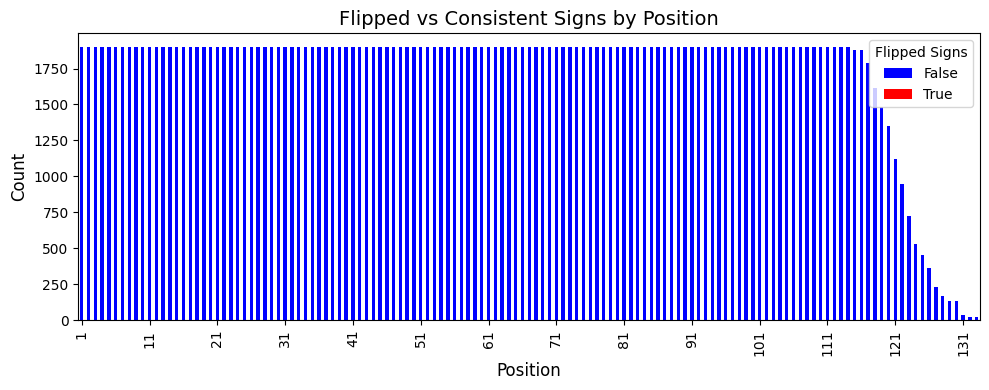

In [27]:
plt.figure(figsize=(12, 6))

# Get count data by position and flipped_signs
count_data = stats_df.groupby(['Position', 'flipped_signs']).size().unstack(fill_value=0)

# Ensure both True and False categories exist
if True not in count_data.columns:
    count_data[True] = 0
if False not in count_data.columns:
    count_data[False] = 0

# Create stacked bar plot
ax = count_data.plot(kind='bar', stacked=True, figsize=(10, 4), 
                    color=['blue', 'red'])  # False, True

# Customize the plot
plt.xlabel('Position', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Flipped vs Consistent Signs by Position', fontsize=14)

# Get all tick positions
positions = ax.get_xticks()
labels = [item.get_text() for item in ax.get_xticklabels()]

# Keep only every 10th tick and label
indices_to_keep = [i for i, position in enumerate(positions) if i % 10 == 0]
positions_to_keep = [positions[i] for i in indices_to_keep]
labels_to_keep = [labels[i] for i in indices_to_keep]

# Set the new ticks and labels
ax.set_xticks(positions_to_keep)
ax.set_xticklabels(labels_to_keep, rotation=90)

plt.legend(title='Flipped Signs')
plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

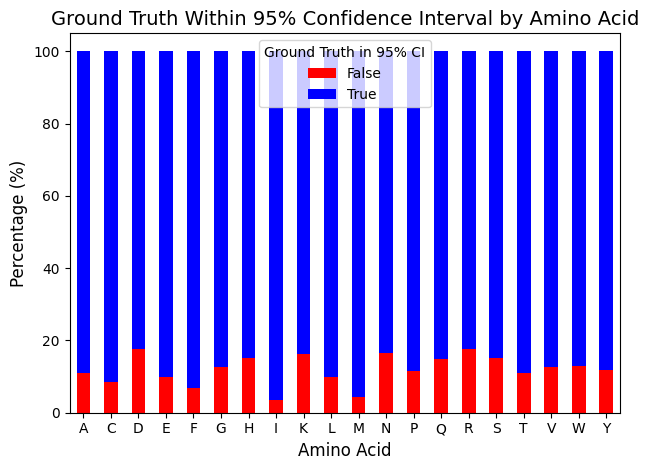

In [28]:
plt.figure(figsize=(6, 4))

# Get count data by AminoAcid and ground_truth_in_0.95_range
count_data = stats_df.groupby(['AminoAcid', 'ground_truth_in_0.95_range']).size().unstack(fill_value=0)

# Ensure both True and False categories exist
if True not in count_data.columns:
    count_data[True] = 0
if False not in count_data.columns:
    count_data[False] = 0

# Calculate the percentage (normalize each row to sum to 100%)
normalized_data = count_data.div(count_data.sum(axis=1), axis=0) * 100

# Create stacked bar plot with normalized data
ax = normalized_data.plot(kind='bar', stacked=True,  
                        color=['red', 'blue'])  # False, True

# Customize the plot
plt.xlabel('Amino Acid', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Ground Truth Within 95% Confidence Interval by Amino Acid', fontsize=14)

# No need for tick filtering since there are only 20 amino acids
plt.xticks(rotation=0)  # No rotation needed for amino acid labels

plt.legend(title='Ground Truth in 95% CI')
plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

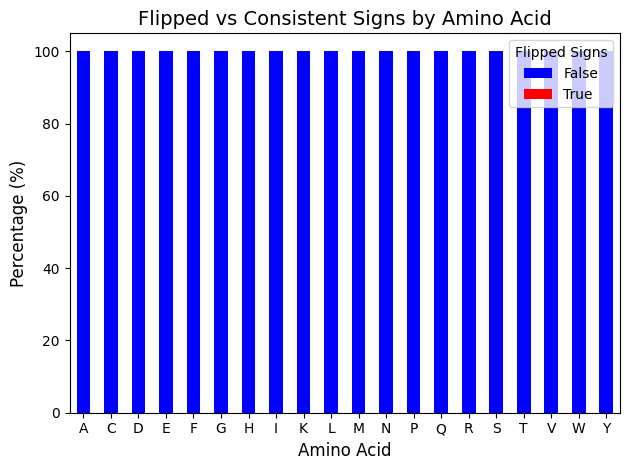

In [29]:
plt.figure(figsize=(6, 4))

# Get count data by AminoAcid and flipped_signs
count_data = stats_df.groupby(['AminoAcid', 'flipped_signs']).size().unstack(fill_value=0)

# Ensure both True and False categories exist
if True not in count_data.columns:
    count_data[True] = 0
if False not in count_data.columns:
    count_data[False] = 0

# Calculate the percentage (normalize each row to sum to 100%)
normalized_data = count_data.div(count_data.sum(axis=1), axis=0) * 100

# Create stacked bar plot with normalized data
ax = normalized_data.plot(kind='bar', stacked=True, 
                        color=['blue', 'red'])  # False, True

# Customize the plot
plt.xlabel('Amino Acid', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Flipped vs Consistent Signs by Amino Acid', fontsize=14)

# No need for tick filtering since there are only 20 amino acids
plt.xticks(rotation=0)  # No rotation needed for amino acid labels

plt.legend(title='Flipped Signs')
plt.tight_layout()
plt.show()

Text(0.5, 0, '|ground truth| - |mean_mc_dropout|')

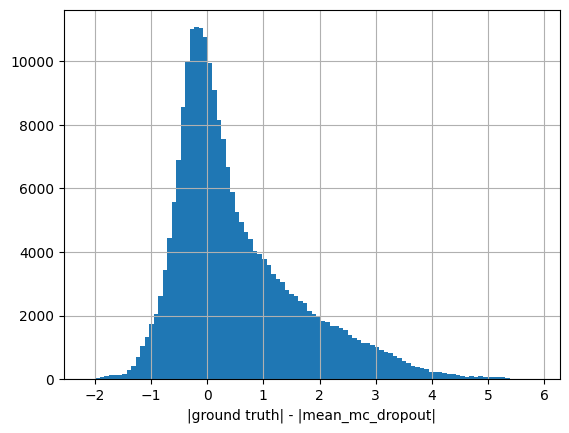

In [30]:
ax = (stats_df['DASM_log_selection_factor'].abs() - stats_df['mean_log_selection_factor'].abs()).hist(bins=100)
ax.set_xlabel('|ground truth| - |mean_mc_dropout|')


Text(0.5, 0, '|ground truth| - |mean_mc_dropout|')

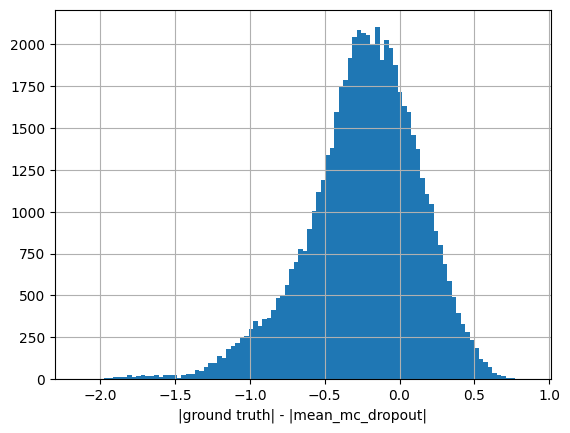

In [31]:
ax = (stats_df[stats_df.DASM_log_selection_factor > 0]['DASM_log_selection_factor'].abs() - stats_df[stats_df.DASM_log_selection_factor > 0]['mean_log_selection_factor'].abs()).hist(bins=100)
ax.set_xlabel('|ground truth| - |mean_mc_dropout|')


Text(0.5, 0, '|ground truth| - |mean_mc_dropout|')

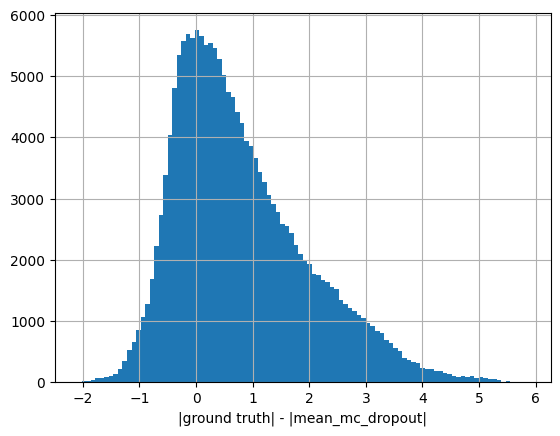

In [32]:
ax = (stats_df[stats_df.DASM_log_selection_factor < 0]['DASM_log_selection_factor'].abs() - stats_df[stats_df.DASM_log_selection_factor < 0]['mean_log_selection_factor'].abs()).hist(bins=100)
ax.set_xlabel('|ground truth| - |mean_mc_dropout|')


#### predictions of the model trained on simulations tend to be "less extreme" for the negative predictions